**This notebook introduces how to train a conditional VAE model from scratch. <br/>**
We first use an encoder to compress the high-dimensional temperature data into latent vectors. Then, we incorporate CO2 & CH4 information into latent vectors, and use an decorder to reconstruct the global temperature map.

By Weiwei Zhan

Reference: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

vary latent space - modify by Rong-Yu Gu, 10/10/23

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Data normalization

normalize the CO2 & CH4 time series

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data

In [6]:
n_lat, n_lon = y_train.shape[1], y_train.shape[2]

normalize the 2-D temperature data 

In [7]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

# Convert to PyTorch datasets
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the VAE architecture

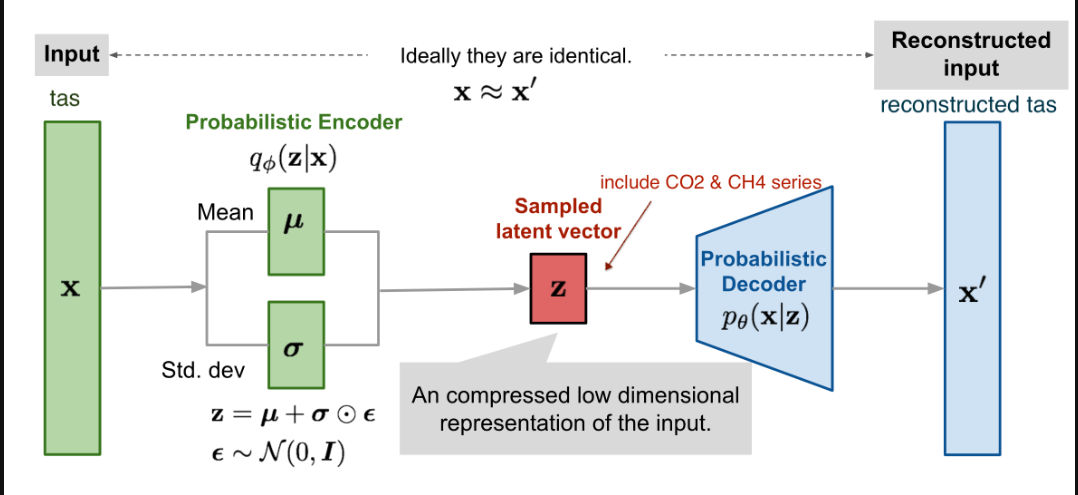

figure source: https://lilianweng.github.io/posts/2018-08-12-vae/

In [8]:
latent_dim = 2   # dimensions of the latent space
n_filters  = 32  # number of filters for the convolutional layers
n_neurons  = 32  # number of neurons for the Dense layers
activation = nn.ReLU() # activation function
kernel_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 50

In [9]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (753, 2)
y_train shape: (753, 96, 144)


#### Build Encoder & Sampling for the latent vector

In [11]:
class Encoder(nn.Module):
    def __init__(self, n_filters, kernel_size, n_neurons, latent_dim):
        super().__init__()
        # downsampling, compressing
        self.conv1 = nn.Conv2d(1, n_filters, kernel_size, stride=2, padding=1)   # (96,144,1) -> (48,72,32)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size, stride=2, padding=1) # (48,72,32) -> (24,36,32)
        self.conv3 = nn.Conv2d(n_filters, n_filters, kernel_size, stride=2, padding=1) # (24,36,32) -> (12,18,32)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(12 * 18 * n_filters, n_neurons)

        self.z_mean = nn.Linear(n_neurons, latent_dim)
        self.z_log_var = nn.Linear(n_neurons, latent_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.flatten(x)
        x = self.activation(self.fc(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var


# sampling
def sample_latent(z_mean, z_log_var):
    eps = torch.randn_like(z_log_var)
    return z_mean + torch.exp(0.5 * z_log_var) * eps

#### Build Decoder

Here we additionally include CO2 & CH4 as Decoder inputs (the `cond_input` variable)

In [12]:
# this is the same arcitecture we used in the CNN!
class Decoder(nn.Module):
    def __init__(self, n_filters, kernel_size, n_neurons, latent_dim, cond_dim=2):
        super().__init__()
        self.n_filters = n_filters
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        # Conditional input processing (CO₂, CH₄)
        self.cond_fc = nn.Sequential(
            nn.Linear(cond_dim, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, n_filters * 12 * 18),
            nn.ReLU()
        )

        # Latent input processing
        self.latent_fc = nn.Sequential(
            nn.Linear(latent_dim, n_filters),
            nn.ReLU()
        )

        self.deconv1 = nn.ConvTranspose2d(
            2 * n_filters, n_filters, kernel_size=kernel_size,
            stride=2, padding=1, output_padding=0
        )
        self.deconv2 = nn.ConvTranspose2d(
            n_filters, n_filters, kernel_size=kernel_size,
            stride=2, padding=1, output_padding=0
        )
        self.deconv3 = nn.ConvTranspose2d(
            n_filters, n_filters, kernel_size=kernel_size,
            stride=2, padding=1, output_padding=0
        )
        self.final = nn.Conv2d(n_filters, 1, kernel_size=3, stride=1, padding=1)
        self.activation = nn.ReLU()

    def forward(self, z, cond):
        cond_feat = self.cond_fc(cond).view(-1, self.n_filters, 12, 18)

        latent_feat = self.latent_fc(z).unsqueeze(-1).unsqueeze(-1)
        latent_feat = latent_feat.expand(-1, self.n_filters, 12, 18)

        # Concatenate features along channel dimension
        x = torch.cat([cond_feat, latent_feat], dim=1)

        # upsample, see CNN notebook for reference
        x = self.activation(self.deconv1(x))
        x = self.activation(self.deconv2(x))
        x = self.activation(self.deconv3(x))
        x = self.final(x)
        return x


#### Build the conditional VAE

In [13]:
class VAE(nn.Module):
    def __init__(self, n_filters, kernel_size, n_neurons, latent_dim, cond_dim=2):
        super().__init__()
        self.encoder = Encoder(n_filters, kernel_size, n_neurons, latent_dim)
        self.decoder = Decoder(n_filters, kernel_size, n_neurons, latent_dim, cond_dim)
        self.latent_dim = latent_dim

    def forward(self, x=None, cond=None, predict=False):
        """
        target data (used only during training)
        cond: conditioning input
        predict: if True, generates z from standard normal (no encoder)
        """
        if predict:
            batch_size = cond.size(0)
            z = torch.zeros(batch_size, self.latent_dim).to(cond.device)
            z_mean, z_log_var = None, None
        else:
            z_mean, z_log_var = self.encoder(x)
            z = sample_latent(z_mean, z_log_var)

        recon = self.decoder(z, cond)
        return recon, z_mean, z_log_var

In [14]:
vae = VAE(n_filters, kernel_size, n_neurons, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

#### Define the loss function: reconstruction loss + KL loss

In [15]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(y_pred, y_true, reduction='mean')

    # KL divergence
    kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

    total_loss = recon_loss + kl_loss
    return total_loss

### 3. Train the VAE model

this can be slow on CPUs

In [16]:
train_losses, val_losses = pytorch_train_VAE(vae.to(device), optimizer, criterion = vae_loss, device = device, 
                                         train_loader = train_loader, 
                                         val_loader = val_loader, 
                                         num_epochs = num_epochs)

Epoch 1/50 | Train Loss: 2.8259 | Val Loss: 2.6858
Epoch 2/50 | Train Loss: 2.1359 | Val Loss: 2.0033
Epoch 3/50 | Train Loss: 1.4442 | Val Loss: 1.0799
Epoch 4/50 | Train Loss: 0.8658 | Val Loss: 0.7269
Epoch 5/50 | Train Loss: 0.6625 | Val Loss: 0.5791
Epoch 6/50 | Train Loss: 0.5692 | Val Loss: 0.5247
Epoch 7/50 | Train Loss: 0.5257 | Val Loss: 0.4893
Epoch 8/50 | Train Loss: 0.4841 | Val Loss: 0.4699
Epoch 9/50 | Train Loss: 0.4651 | Val Loss: 0.4622
Epoch 10/50 | Train Loss: 0.4491 | Val Loss: 0.4450
Epoch 11/50 | Train Loss: 0.4357 | Val Loss: 0.4374
Epoch 12/50 | Train Loss: 0.4255 | Val Loss: 0.4345
Epoch 13/50 | Train Loss: 0.4187 | Val Loss: 0.4234
Epoch 14/50 | Train Loss: 0.4113 | Val Loss: 0.4269
Epoch 15/50 | Train Loss: 0.4109 | Val Loss: 0.4141
Epoch 16/50 | Train Loss: 0.3999 | Val Loss: 0.4078
Epoch 17/50 | Train Loss: 0.3964 | Val Loss: 0.4042
Epoch 18/50 | Train Loss: 0.3911 | Val Loss: 0.4019
Epoch 19/50 | Train Loss: 0.3905 | Val Loss: 0.4094
Epoch 20/50 | Train L

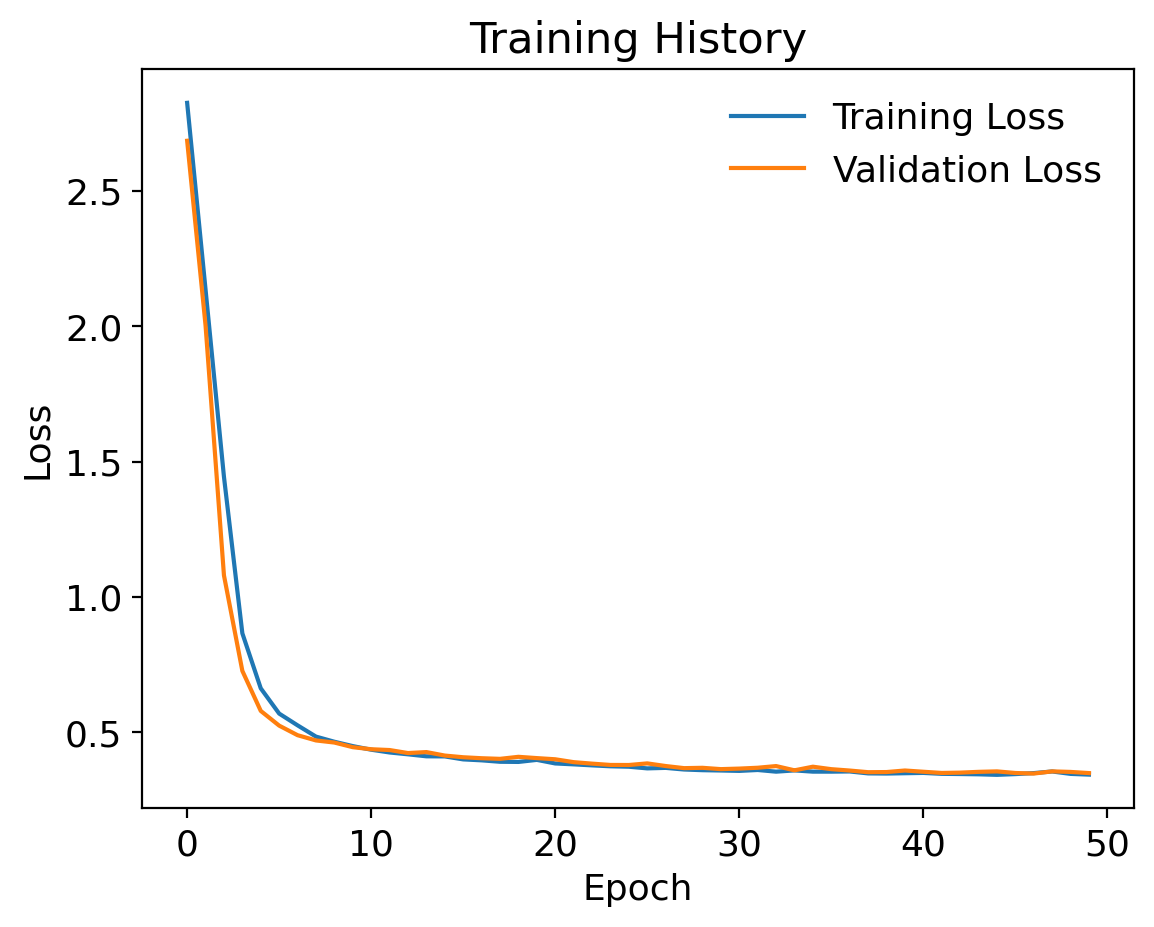

In [17]:
plot_history(train_losses, val_losses)

### 4. evaluate the model performance

Let's test the reconstruction capabilities of our VAE model on the test set.

In [18]:
# we don't provide the temperature field to the VAE during testing, just the conditioning
# with predict = True our vae class uses a zero vector

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)
vae.eval()
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)  # conditioning input only
        recon, _, _ = vae(x=None, cond=batch_X, predict=True)
        # when we set predict to True we use the (theoretical) center of the latent space
        predictions.append(recon.cpu().numpy())

y_test_pre = np.concatenate(predictions, axis=0)
y_test_pre = y_test_pre.squeeze() 
# wrap as xarray Dataset
y_test_pre = xr.Dataset(
    coords={'time': X_test_xr.time.values, 
            'latitude': X_test_xr.latitude.values, 
            'longitude': X_test_xr.longitude.values},
    data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre))
)

Comparisons in terms of the spatial distribution

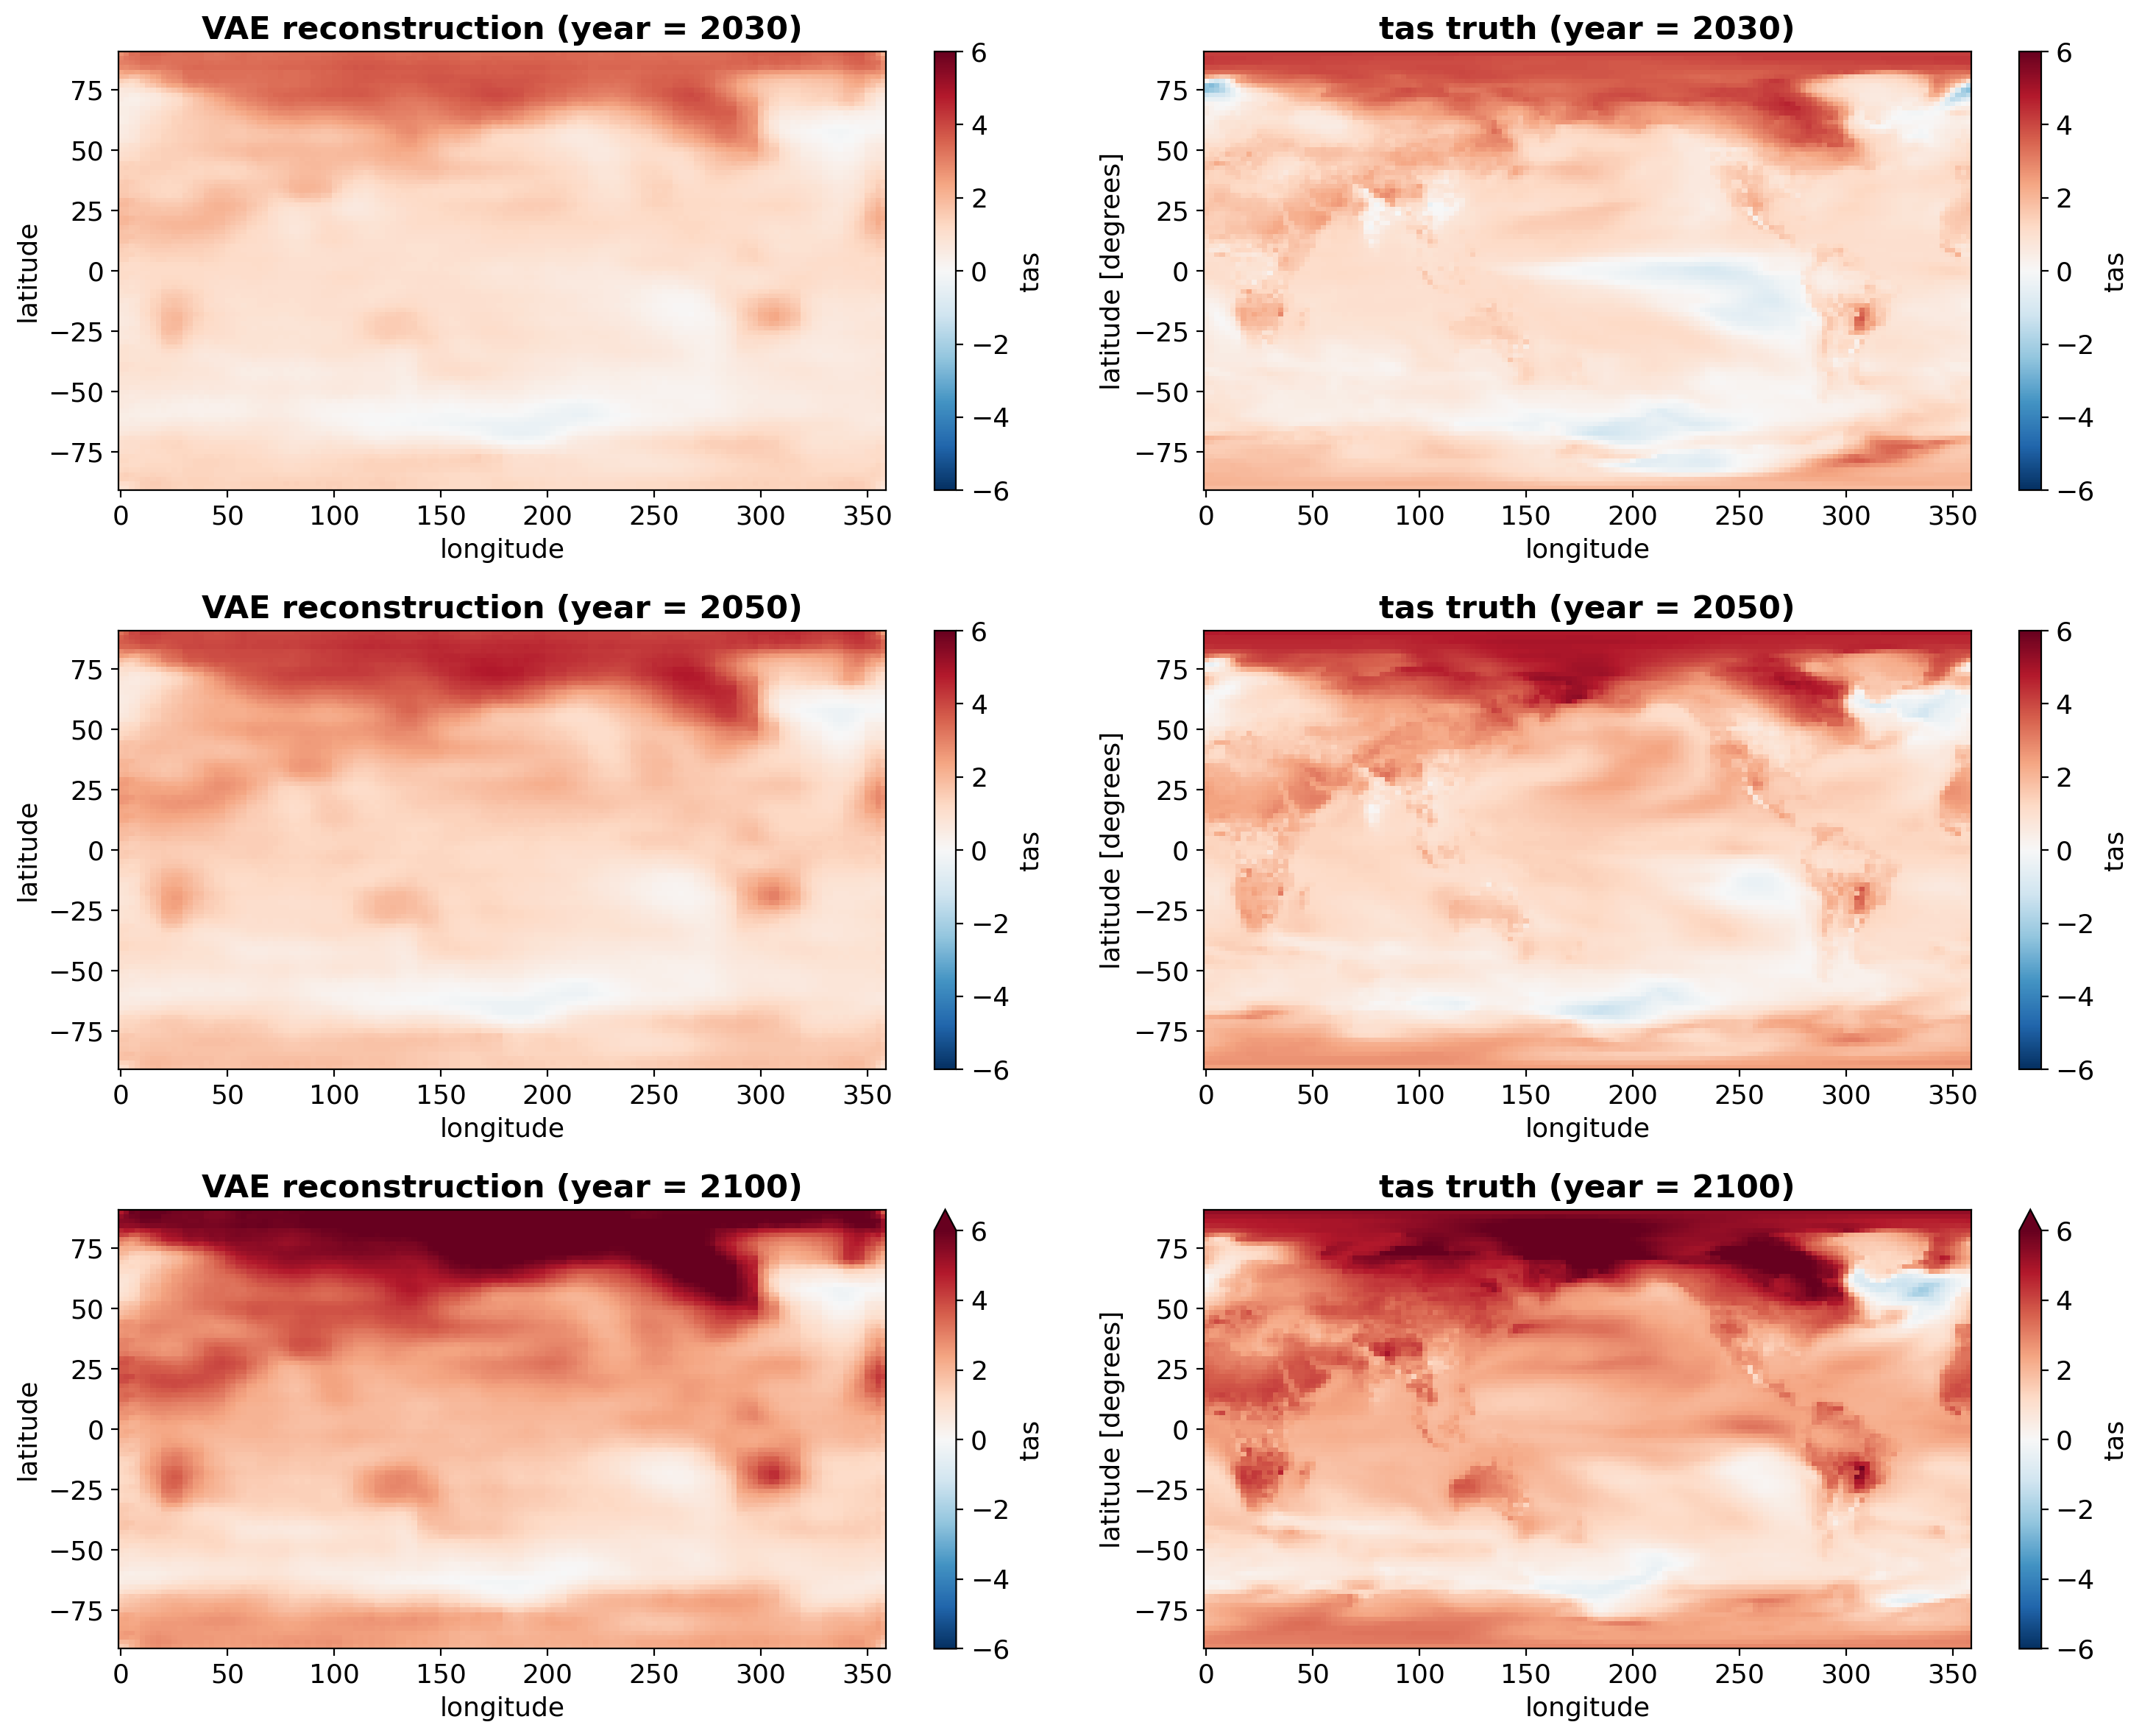

In [19]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Comparisons in terms of the temporal variability (under the ssp245 scenario)

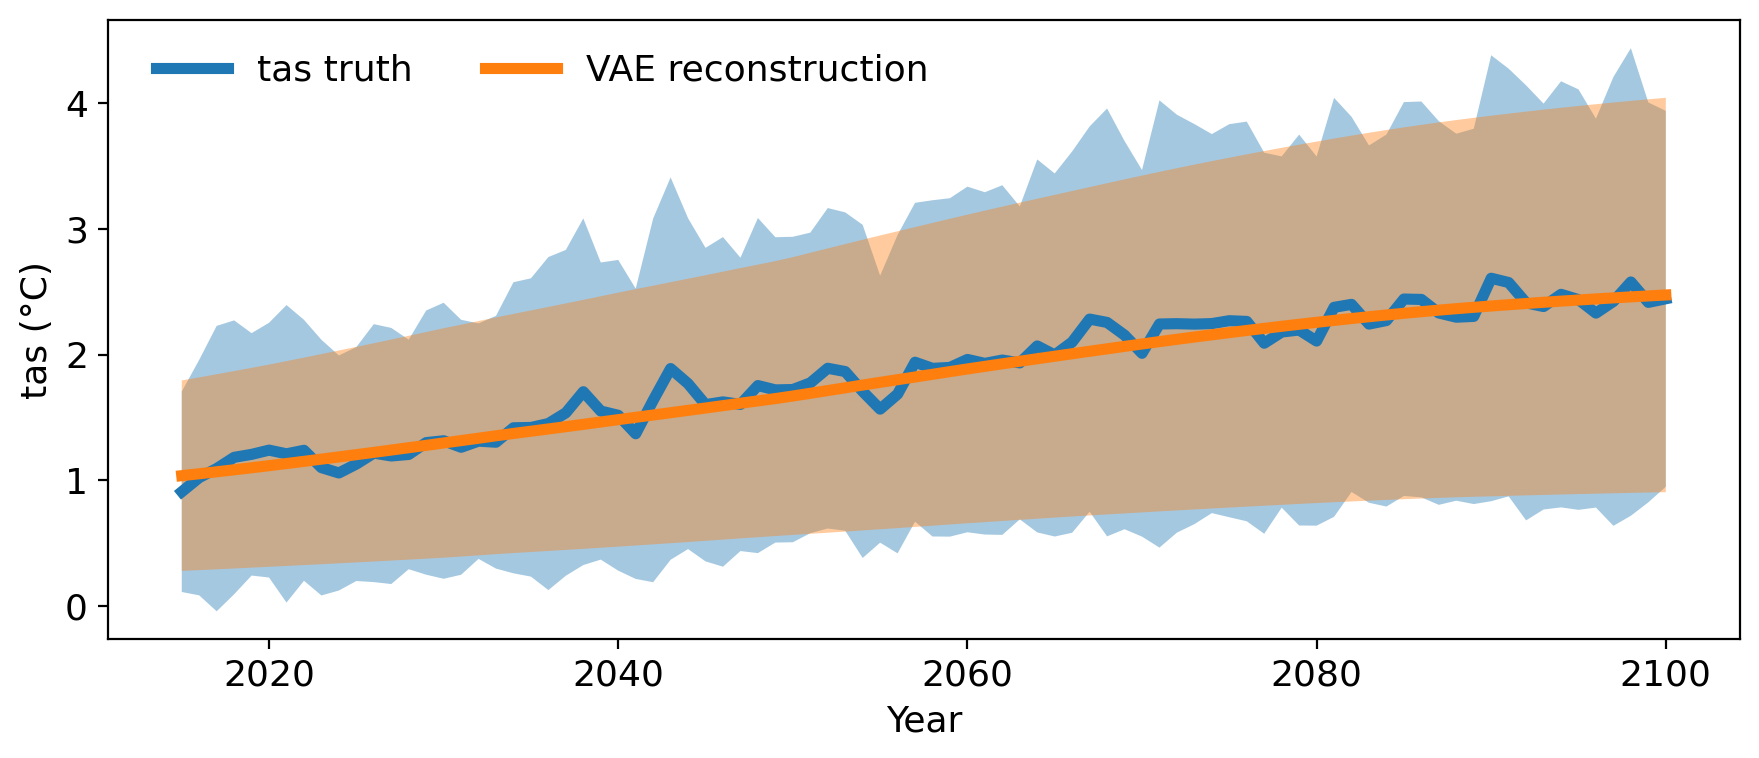

In [20]:
fig, ax = plt.subplots(figsize=(9,4))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas (°C)')
fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)

plt.tight_layout()

### 5. check how the latent space affect model output

Here we display a simple way to show how the latent space affect model output. We vary z in each dimension respectively and pass it through the decoder, which means the decoder is conditioned on a different z value. Then, we plot and compare the model output between the original z and a varied z.

First, let's look at the distribution of z in each dimension.


In [21]:
# now we do give the vae the test y data, just so we can explore the latent space!

vae.eval()
z_all = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)  # shape: (batch_size, 2)
        batch_y = batch_y.unsqueeze(1).to(device) 
        _ , z_mean, _ = vae(batch_y, batch_X) # 
        z_all.append(z_mean.cpu().numpy())
        

# concatenate all batches
z_all = np.concatenate(z_all, axis=0)

shape of latent space =  (86, 2)
latent space for the first 5 years of test data =  [[0.00614871 0.00944538]
 [0.00617336 0.00978298]
 [0.00612996 0.01079339]
 [0.00547422 0.0108722 ]
 [0.00406044 0.00884082]]


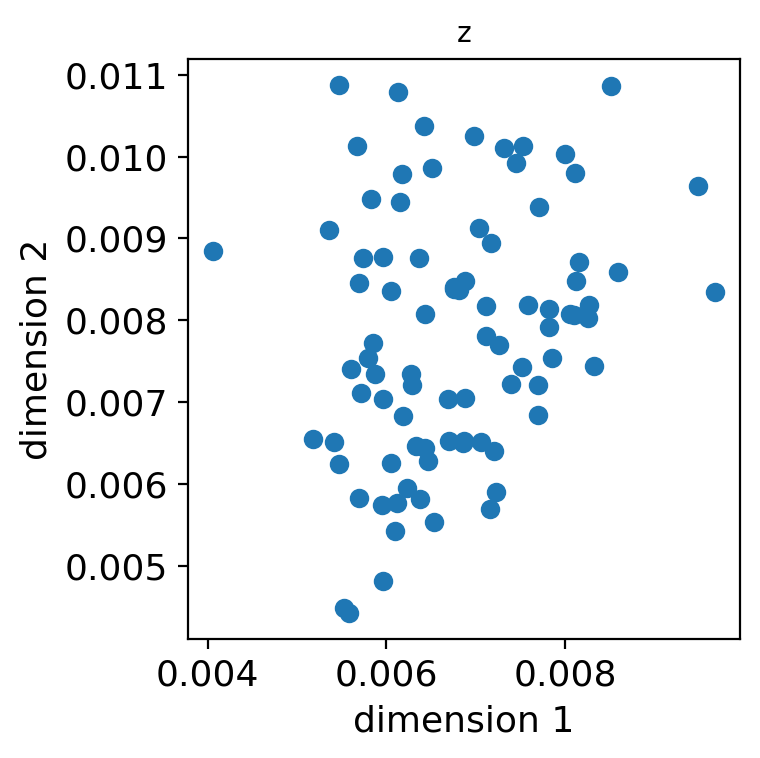

In [22]:
### visualize the latent space (z)
print("shape of latent space = ", np.shape(z_all)) # shape of z = (test_years, latent_dim)
print("latent space for the first 5 years of test data = ", z_all[0:5,:])

# fit a normal distribution on z
mu_fit1, std_fit1 = norm.fit(z_all[:,0])
mu_fit2, std_fit2 = norm.fit(z_all[:,1])

## plot z
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(z_all[:,0],z_all[:,1])

plt.title("z", fontsize=10)
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.tight_layout()



Then, we vary z as a arbitary value in each dimension respectively. In this example, we only implement a varied z in the first year of the output (year = 2015).

In [23]:
### Varying latent space
z_std = z_all.std()
# D1
z1 = np.copy(z_all)
z1[[0], 0] = z1[[0], 0] - 3*z_std # vary latent space dim 1 at year 2015
print("original z[[0],0] = ", np.round(z_all[[0],0], 4),
      ", new z[[0],0] =", np.round(z1[[0],0], 4))

# Convert to torch tensors
z1_tensor = torch.FloatTensor(z1).to(device)
cond_tensor = torch.FloatTensor(X_test).to(device)  # CO2/CH4 inputs

# Decode using modified z1
vae.eval()
with torch.no_grad():
    y_test_pre_varyz1 = vae.decoder(z1_tensor, cond_tensor).cpu().numpy()

# Rescale and reshape
y_test_pre_varyz1 = y_test_pre_varyz1.squeeze(1)
y_test_pre_varyz1 = y_test_pre_varyz1.reshape(y_test_pre_varyz1.shape[0], 96, 144)

y_test_pre_varyz1 = xr.Dataset(
    coords={
        'time': y_test_xr.time.values,
        'latitude': y_test_xr.latitude.values,
        'longitude': y_test_xr.longitude.values
    },
    data_vars=dict(
        tas=(['time', 'latitude', 'longitude'], y_test_pre_varyz1)
    )
)


# D2
z2 = np.copy(z_all)
z2[[0], 1] = z2[[0], 1] - 3*z_std # vary latent space dim 2 at year 2015
print("original z[[0],1] = ", np.round(z_all[[0],1], 4),
      ", new z[[0],1] =", np.round(z2[[0],1], 4))

# Convert to torch tensors
z2_tensor = torch.FloatTensor(z2).to(device)

# Decode using modified z2
vae.eval()
with torch.no_grad():
    y_test_pre_varyz2 = vae.decoder(z2_tensor, cond_tensor).cpu().numpy()

# Rescale and reshape
y_test_pre_varyz2 = y_test_pre_varyz2.squeeze(1)
y_test_pre_varyz2 = y_test_pre_varyz2.reshape(y_test_pre_varyz2.shape[0], 96, 144)

y_test_pre_varyz2 = xr.Dataset(
    coords={
        'time': y_test_xr.time.values,
        'latitude': y_test_xr.latitude.values,
        'longitude': y_test_xr.longitude.values
    },
    data_vars=dict(
        tas=(['time', 'latitude', 'longitude'], y_test_pre_varyz2)
    )
)


original z[[0],0] =  [0.0061] , new z[[0],0] = [0.002]
original z[[0],1] =  [0.0094] , new z[[0],1] = [0.0052]


Compare the varied z output with the original output

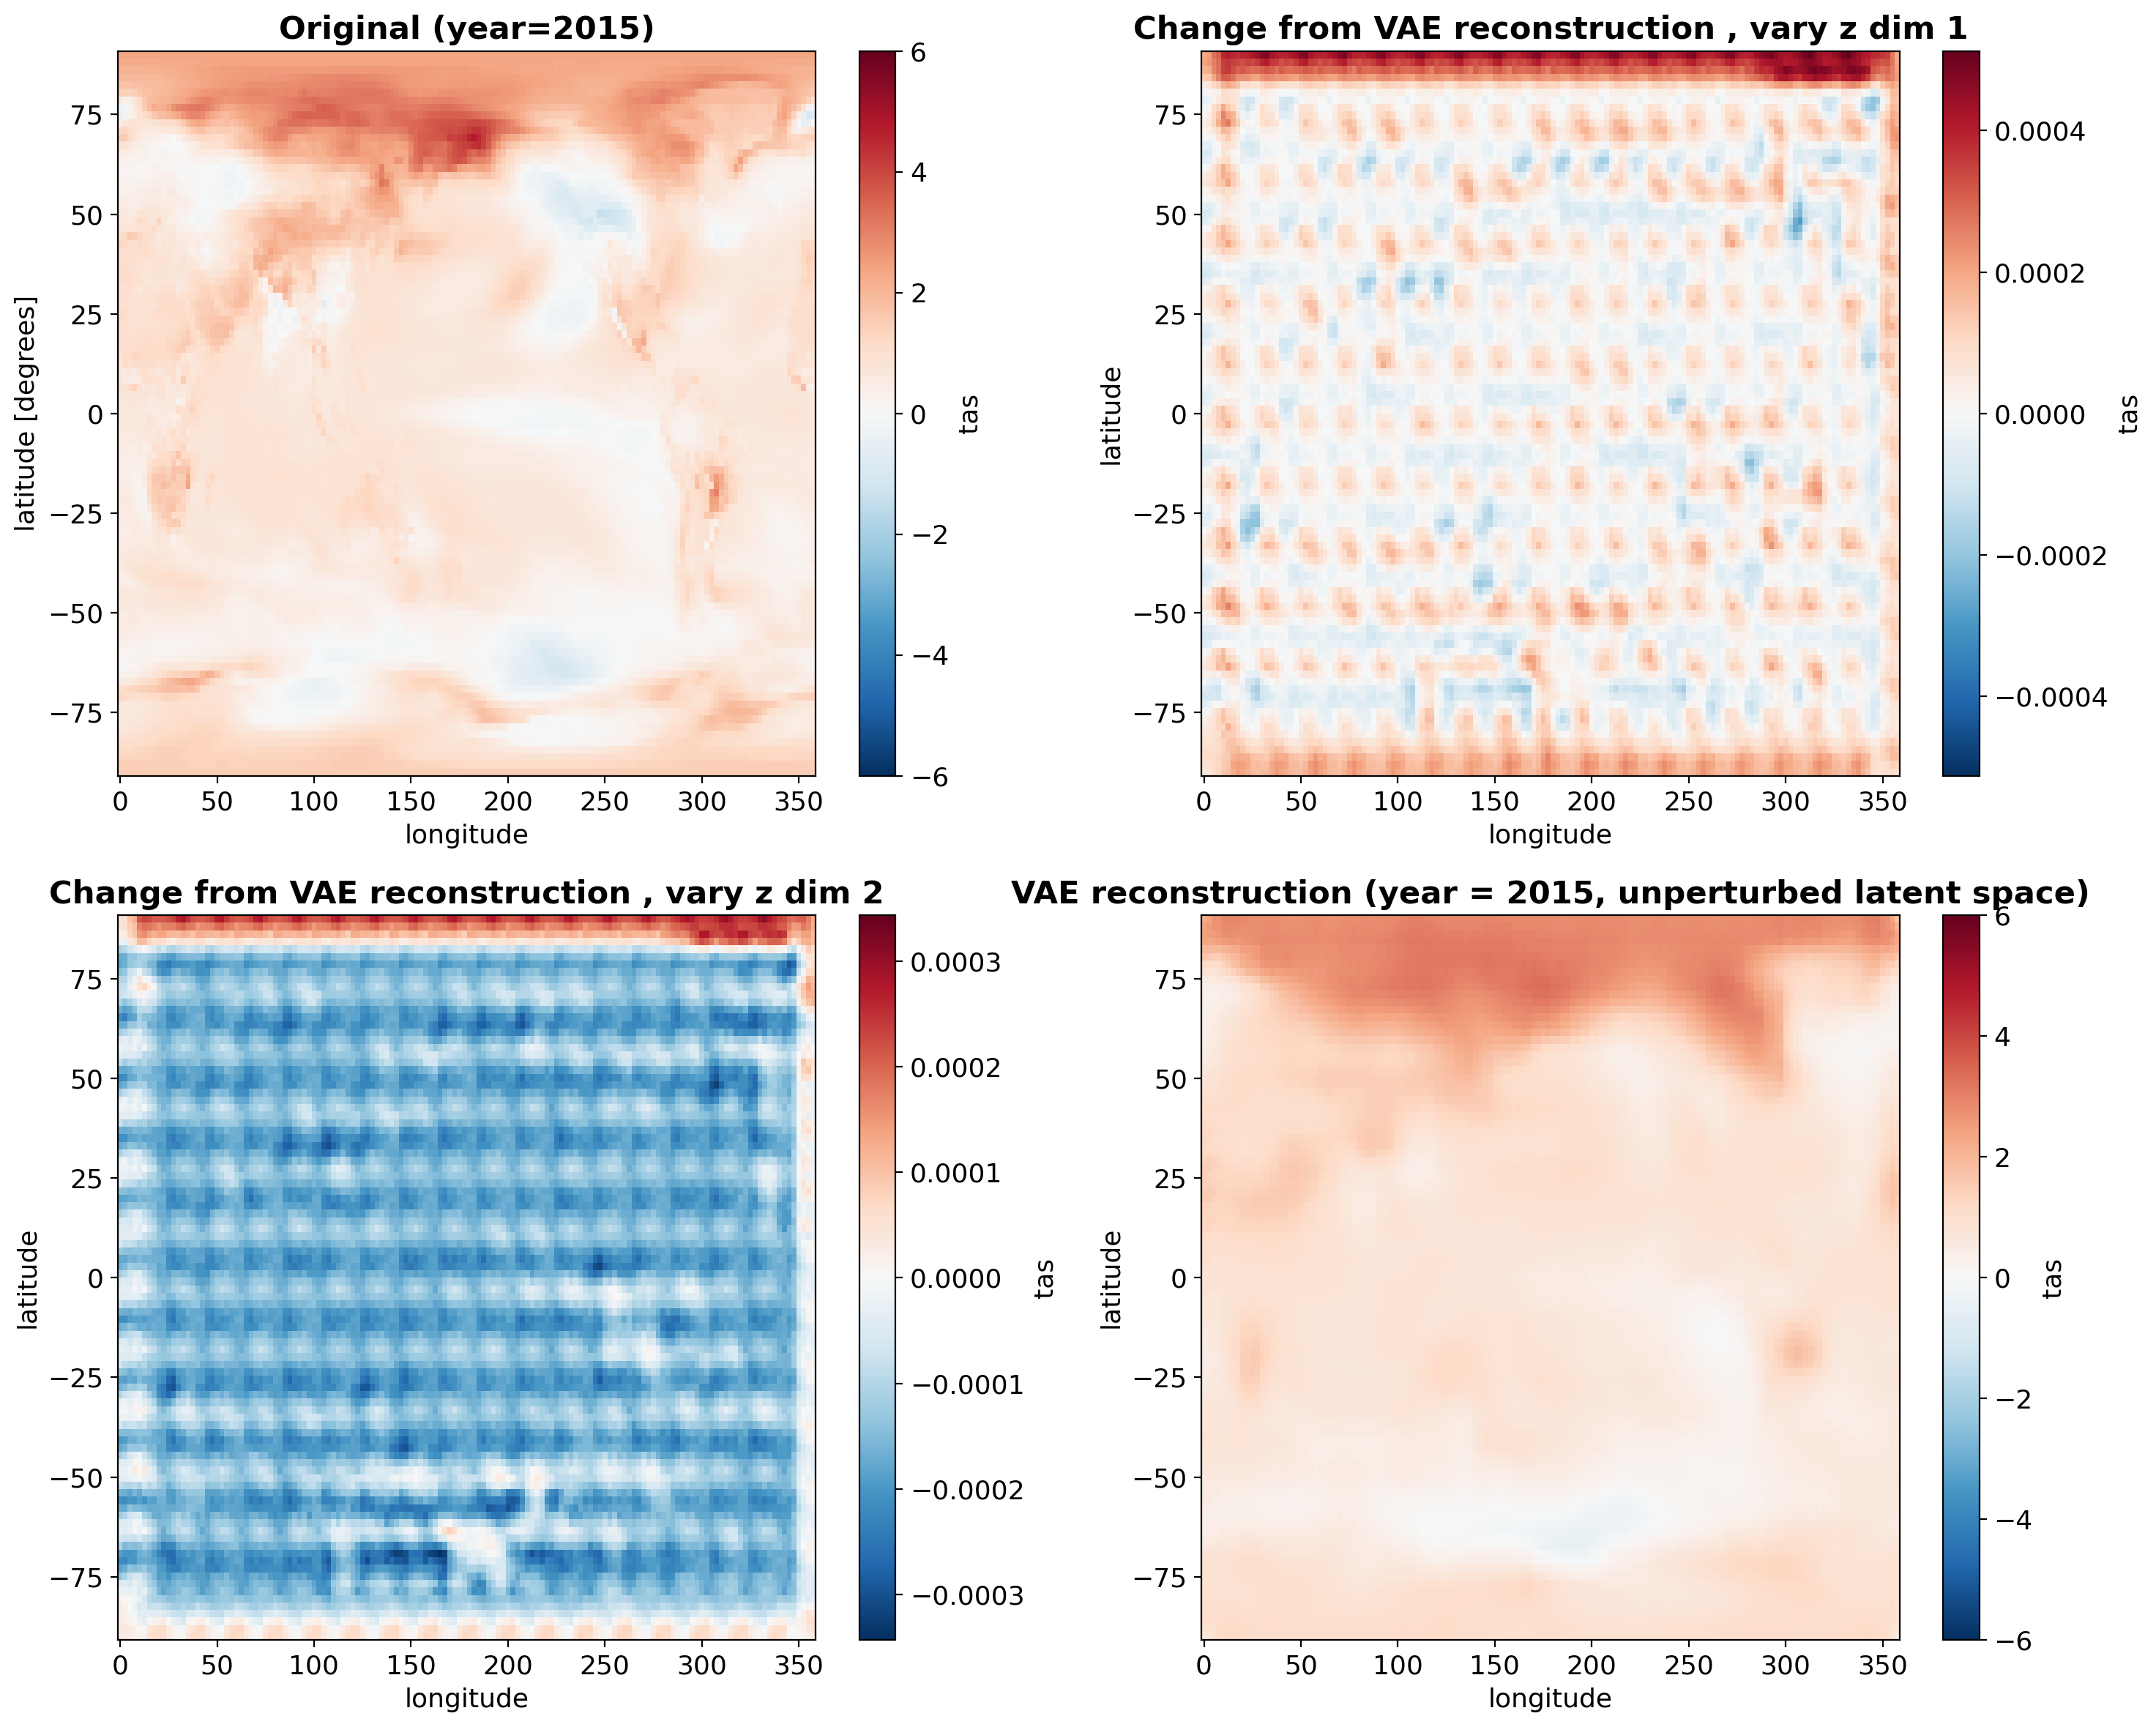

In [24]:
fig, axes = plt.subplots(figsize=(15,12), ncols=2, nrows=2)
vmin, vmax = -6, 6
vmin_changes, vmax_changes = None, None
cmap = 'RdBu_r'

# Original data
y_test_xr.tas.sel(time=2015).plot(ax=axes[0,0], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0,0].set_title('Original (year=2015)', fontweight='bold')

# Difference: vary z dim 1 - VAE reconstruction
(y_test_pre_varyz1.tas.sel(time=2015) - y_test_pre.tas.sel(time=2015)).plot(
    ax=axes[0,1], vmin=vmin_changes, vmax=vmax_changes, cmap=cmap
)
axes[0,1].set_title('Change from VAE reconstruction , vary z dim 1', fontweight='bold')

# Difference: vary z dim 2 - VAE reconstruction
(y_test_pre_varyz2.tas.sel(time=2015) - y_test_pre.tas.sel(time=2015)).plot(
    ax=axes[1,0], vmin=vmin_changes, vmax=vmax_changes, cmap=cmap
)
axes[1,0].set_title('Change from VAE reconstruction , vary z dim 2', fontweight='bold')

# VAE reconstruction
(y_test_pre.tas.sel(time=2015)).plot(
    ax=axes[1,1], vmin=vmin, vmax=vmax, cmap=cmap
)
axes[1,1].set_title('VAE reconstruction (year = 2015, unperturbed latent space)', fontweight='bold')

plt.tight_layout()
plt.show()